In [251]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [252]:
MAXIMUM_Q_VALUE = 0.005
ANALYSE_RECALIBRATED_FEATURES = True

In [253]:
if ANALYSE_RECALIBRATED_FEATURES:
    PERCOLATOR_OUTPUT_FILE = '/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/recalibrated-percolator-output/190719_Hela_Ecoli.percolator.target.psms.txt'
    PERCOLATOR_STDOUT_FILE = '/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/recalibrated-percolator-output/recalibrated-percolator-stdout.log'
    FEATURE_FILE = '/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/recalibrated-features/{}-features.pkl'
else:
    PERCOLATOR_OUTPUT_FILE = '/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/percolator-output/190719_Hela_Ecoli.percolator.target.psms.txt'
    PERCOLATOR_STDOUT_FILE = '/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/percolator-output/percolator-stdout.log'
    FEATURE_FILE = '/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/features/{}-features.pkl'


In [254]:
psms_df = pd.read_csv(PERCOLATOR_OUTPUT_FILE, sep='\t')
psms_df = psms_df[psms_df['percolator q-value'] <= MAXIMUM_Q_VALUE]

In [255]:
psms_df[psms_df.file_idx == 0].sort_values(by='scan').head()

,file_idx,scan,charge,spectrum precursor m/z,spectrum neutral mass,peptide mass,percolator score,percolator q-value,percolator PEP,total matches/spectrum,sequence,protein id,flanking aa
85528,0,3,2,871.9096,1741.8046,1742.8120,0.863303,0.000003,2.177940e-08,3292.08,AMGIMNSFVNDIFER,"sp|Q5QNW6|H2B2F_HUMAN,sp|Q99879|H2B1M_HUMAN,sp...",KI
381962,0,4,2,901.9437,1801.8728,1802.8799,0.472076,0.000003,5.196051e-05,3292.08,GITINTSHVEYDTPTR,"sp|P0CE48|EFTU2_ECOLI,sp|P0CE47|EFTU1_ECOLI",RH
22826,0,5,3,801.0827,2400.2263,2401.2336,1.047681,0.000003,5.560437e-10,3292.08,ANDAAGDGTTTATVLAQAIITEGLK,sp|P0A6F5|CH60_ECOLI,KA
221,0,6,2,1093.0820,2184.1494,2128.1350,1.533166,0.000003,3.554143e-14,3292.08,IPISGIAGDQQAALFGQLCVK,sp|P0A6F3|GLPK_ECOLI,RE
282742,0,7,2,965.5842,1929.1539,1930.1615,0.595956,0.000003,4.442605e-06,3292.08,VTIAQGGVLPNIQAVLLPK,"sp|Q99878|H2A1J_HUMAN,sp|Q9BTM1|H2AJ_HUMAN,sp|...",KK


In [256]:
# use the recalibrated percolator output to find the mapping from percolator index to run
mapping = []
with open(PERCOLATOR_STDOUT_FILE) as f:
    lines = f.readlines()
    for line in lines:
        if line.startswith('INFO: Assigning index'):
            splits = line.split(' ')
            percolator_index = int(splits[3])
            comet_filename = splits[5]
            base_name = comet_filename.split('/')[-1].split('.')[0]
            mapping.append((percolator_index, base_name))

In [257]:
mapping

[(0, '190719_Hela_Ecoli_1to3_06-recalibrated'),
 (1, '190719_Hela_Ecoli_1to1_07-recalibrated'),
 (2, '190719_Hela_Ecoli_1to1_09-recalibrated'),
 (3, '190719_Hela_Ecoli_1to3_05-recalibrated'),
 (4, '190719_Hela_Ecoli_1to3_09-recalibrated'),
 (5, '190719_Hela_Ecoli_1to3_08-recalibrated'),
 (6, '190719_Hela_Ecoli_1to3_07-recalibrated'),
 (7, '190719_Hela_Ecoli_1to3_01-recalibrated'),
 (8, '190719_Hela_Ecoli_1to3_10-recalibrated'),
 (9, '190719_Hela_Ecoli_1to3_04-recalibrated'),
 (10, '190719_Hela_Ecoli_1to1_02-recalibrated'),
 (11, '190719_Hela_Ecoli_1to1_10-recalibrated'),
 (12, '190719_Hela_Ecoli_1to1_04-recalibrated'),
 (13, '190719_Hela_Ecoli_1to1_06-recalibrated'),
 (14, '190719_Hela_Ecoli_1to1_03-recalibrated'),
 (15, '190719_Hela_Ecoli_1to1_08-recalibrated'),
 (16, '190719_Hela_Ecoli_1to3_03-recalibrated'),
 (17, '190719_Hela_Ecoli_1to1_01-recalibrated'),
 (18, '190719_Hela_Ecoli_1to1_05-recalibrated'),
 (19, '190719_Hela_Ecoli_1to3_02-recalibrated')]

In [258]:
# combine the features detected across the whole experiment into a single dataframe
df_l = []
for m in mapping:
    idx = m[0]
    filename = m[1]
    df = pd.read_pickle(FEATURE_FILE.format(filename))
    df['percolator_idx'] = idx
    df['batch'] = filename.split('_')[3]
    df_l.append(df)
# make a single df from the list of dfs
features_df = pd.concat(df_l, axis=0, sort=False)

In [259]:
len(features_df[features_df.percolator_idx == 0])

149261

In [260]:
# merge the features with the experiment-wide percolator identifications
percolator_df = pd.merge(psms_df, features_df, how='left', left_on=['file_idx','scan'], right_on=['percolator_idx','feature_id'])
percolator_df['human'] = percolator_df['protein id'].str.contains('HUMAN')

In [261]:
len(percolator_df)

566829

In [262]:
# find the maximum-intensity feature for a unique sequence and charge in each file
sequences_l = []
for group_name,group_df in percolator_df.groupby(['file_idx','sequence','charge_x'], as_index=False):
    batch = group_df.iloc[0].batch  # 1to1 or 1to3
    file_idx = group_name[0]
    sequence = group_name[1]
    charge = group_name[2]
    intensity = group_df.intensity.max()
    human = group_df.iloc[0].human
    sequence_count_in_file = len(group_df)  # how many times this sequence and charge was identified in this run
    sequences_l.append((batch, file_idx, sequence, charge, intensity, human, sequence_count_in_file))

In [263]:
sequences_df = pd.DataFrame(sequences_l, columns=['batch','file_idx','sequence','charge','intensity','human','count_in_file'])

In [264]:
sequences_df.head()

,batch,file_idx,sequence,charge,intensity,human,count_in_file
0,1to3,0,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,162746.0,True,2
1,1to3,0,AAAAAAAAVPSAGPAGPAPTSAAGR,2,58153.0,True,3
2,1to3,0,AAAAAWEEPSSGNGTAR,2,258410.0,True,1
3,1to3,0,AAAAPVTGPLADDPIQETITFDDFAK,3,203979.0,False,1
4,1to3,0,AAAEDVNVTFEDQQK,2,74963.0,True,1


In [265]:
# for each sequence and charge, if it was found in more than 5 of the 1to1 and 5 of the 1to3 runs, 
# find the mean intensity in each batch, then find the intensity ratio between batches
sequence_occurences_in_batch = []
for group_name,group_df in sequences_df.groupby(['sequence','charge'], as_index=False):
    sequence_in_1to1_df = group_df[group_df.batch == '1to1']
    sequence_in_1to3_df = group_df[group_df.batch == '1to3']
    if (len(sequence_in_1to1_df) >= 5) and (len(sequence_in_1to3_df) >= 5):
        average_intensity_in_1to1 = sequence_in_1to1_df.intensity.mean()
        average_intensity_in_1to3 = sequence_in_1to3_df.intensity.mean()
        human = group_df.iloc[0].human
        sequence = group_name[0]
        charge = group_name[1]
        sequence_occurences_in_batch.append((sequence, charge, average_intensity_in_1to1, average_intensity_in_1to3, human))

In [266]:
sequence_occurences_in_batch_df = pd.DataFrame(sequence_occurences_in_batch, columns=['sequence','charge','intensity_1to1','intensity_1to3','human'])

In [267]:
sequence_occurences_in_batch_df.head()

,sequence,charge,intensity_1to1,intensity_1to3,human
0,AAAAAAAAVPSAGPAGPAPTSAAGR,2,70306.000000,56008.200000,True
1,AAAAATVVPPMVGGPPFVGPVGFGPGDR,3,50455.833333,55671.000000,True
2,AAAAAWEEPSSGNGTAR,2,367740.200000,284638.900000,True
3,AAAEDVNVTFEDQQK,2,194934.125000,74928.695051,True
4,AAAEELQEAAGAGDGATENGVQPPK,2,80061.100000,72475.000000,True


In [268]:
sequence_occurences_in_batch_df['intensity_ratio'] = sequence_occurences_in_batch_df.intensity_1to3 / sequence_occurences_in_batch_df.intensity_1to1

In [269]:
human_df = sequence_occurences_in_batch_df[sequence_occurences_in_batch_df.human == True]
ecoli_df = sequence_occurences_in_batch_df[sequence_occurences_in_batch_df.human == False]

In [270]:
len(human_df), len(ecoli_df)

(8871, 2193)

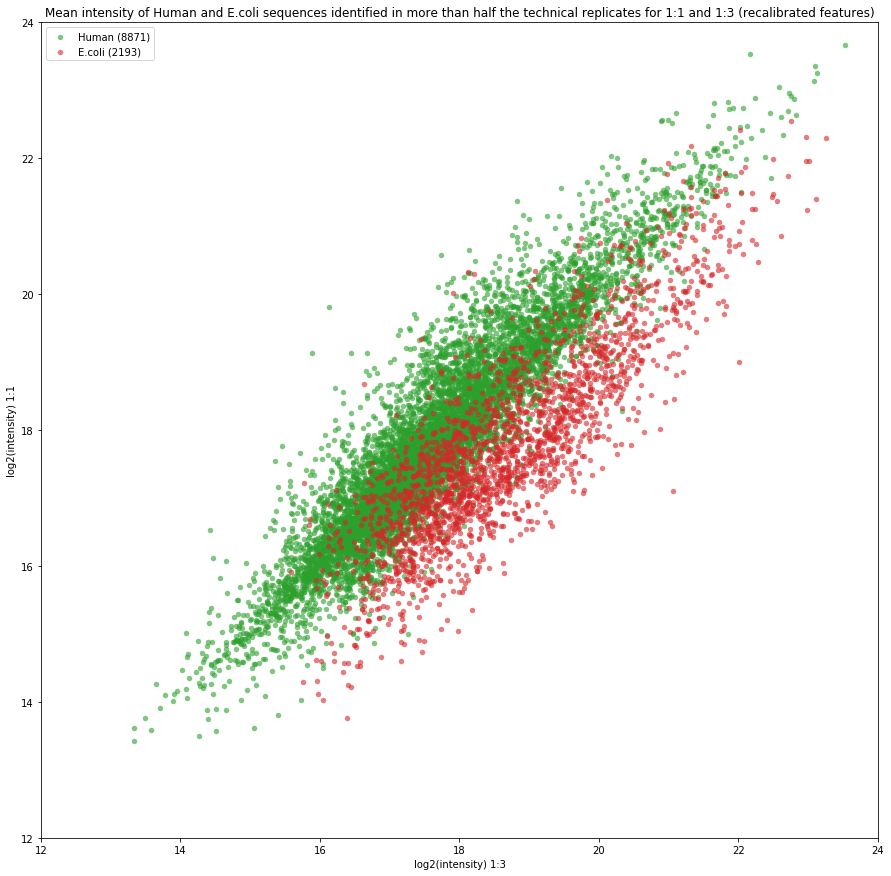

In [271]:
# For each sequence-charge identified in more than 5 runs in 1to1 and more than 5 runs in 1to3, take the average intensity in 
# each batch and plot their intensity. We should expect to see a shift in the E.coli sequences because they are 3 
# times more concentrated in the 1:3 batch.
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
plt.margins(0.06)

title = 'Mean intensity of Human and E.coli sequences identified in more than half the technical replicates for 1:1 and 1:3'
if ANALYSE_RECALIBRATED_FEATURES:
    title += ' (recalibrated features)'
plt.title(title)

ax.scatter(np.log2(human_df.intensity_1to3), np.log2(human_df.intensity_1to1), marker='o', color='tab:green', lw=0, s=30, alpha=0.6, label="Human ({})".format(len(human_df)))
ax.scatter(np.log2(ecoli_df.intensity_1to3), np.log2(ecoli_df.intensity_1to1), marker='o', color='tab:red', lw=0, s=30, alpha=0.6, label="E.coli ({})".format(len(ecoli_df)))

plt.legend(loc='best')
plt.xlabel('log2(intensity) 1:3')
plt.ylabel('log2(intensity) 1:1')

plt.xlim((12,24))
plt.ylim((12,24))

plt.show()

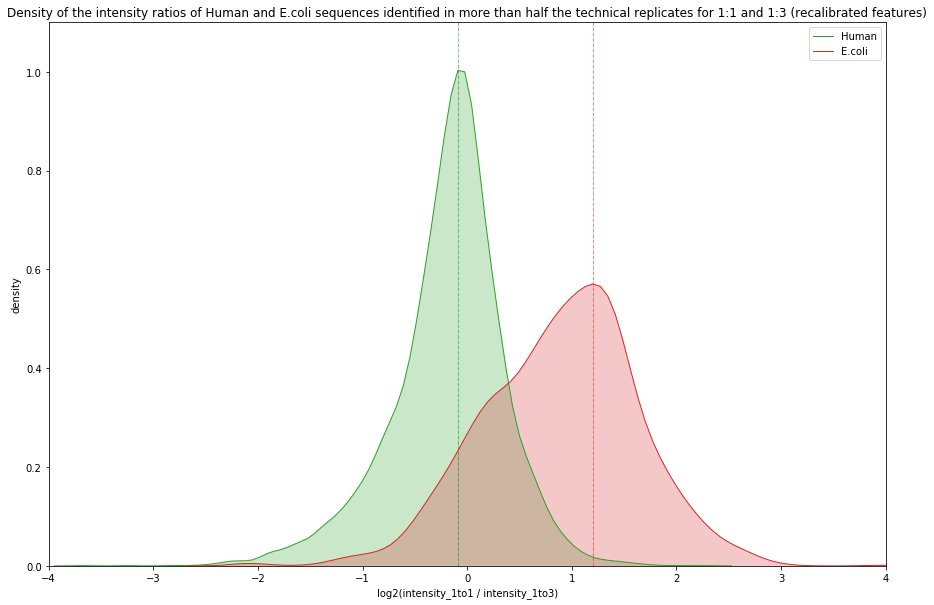

In [272]:
import seaborn as sns
plt.figure(figsize=(15, 10))

title = 'Density of the intensity ratios of Human and E.coli sequences identified in more than half the technical replicates for 1:1 and 1:3'
if ANALYSE_RECALIBRATED_FEATURES:
    title += ' (recalibrated features)'
plt.title(title)

plt.xlim((-4,4))
plt.ylim((0,1.1))

ax = sns.distplot(np.log2(human_df['intensity_ratio']), hist = False, color='tab:green', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Human')
_ = sns.distplot(np.log2(ecoli_df['intensity_ratio']), hist = False, color='tab:red', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'E.coli')

x = ax.lines[0].get_xdata()
y = ax.lines[0].get_ydata()
plt.axvline(x[np.argmax(y)], color='green', lw=0.5, ls='-.')

x = ax.lines[1].get_xdata()
y = ax.lines[1].get_ydata()
plt.axvline(x[np.argmax(y)], color='red', lw=0.5, ls='-.')

_ = ax.set(xlabel='log2(intensity_1to1 / intensity_1to3)', ylabel='density')